In [193]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
from sklearn.preprocessing import RobustScaler 
import optuna
from optuna.samplers import TPESampler
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor, AdaBoostRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor



In [194]:
#define wrangle function
def wrangle(dataset):
    #read csv
    df = pd.read_csv(dataset)
    #cols to drop
    cols_to_drop = ['PoolQC','Alley','MiscFeature','Fence', 'FireplaceQu','MasVnrType', 'Id']

    #handle categorical missingness
    categ_vars = df.select_dtypes('object').columns
    for cat_col in categ_vars:
        df[cat_col] = df[cat_col].fillna(df[cat_col].mode()[0])
    
    #handle numerical missingness
    num_cols = df.select_dtypes(['int','float']).columns
    for num in num_cols:
        df[num] = df[num].fillna(df[num].mean())

    df['TFlrSF'] = df['1stFlrSF'] + df['2ndFlrSF']

    

    #drop multicollinearity
    collinear = ['BedroomAbvGr','GarageYrBlt', 'GarageCars', 'GrLivArea', '1stFlrSF', '2ndFlrSF']
    

    #append
    cols_to_drop.extend(collinear)

    #handle outliers
    Q1 = df['SalePrice'].quantile(0.25)
    Q3 = df['SalePrice'].quantile(0.75)
    IQR = Q3 - Q1

    # Define bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter the entire DataFrame based on SalePrice bounds
    df = df[(df['SalePrice'] >= lower_bound) & (df['SalePrice'] <= upper_bound)]
    

    #drop cols
    df.drop(columns = cols_to_drop, inplace=True)
    df['SalePrice'] = np.log1p(df['SalePrice'])

    return df

In [195]:
df = wrangle('train.csv')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TFlrSF
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,2,2008,WD,Normal,12.247699,1710
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,5,2007,WD,Normal,12.109016,1262
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,9,2008,WD,Normal,12.317171,1786
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,2,2006,WD,Abnorml,11.849405,1717
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,12,2008,WD,Normal,12.429220,2198


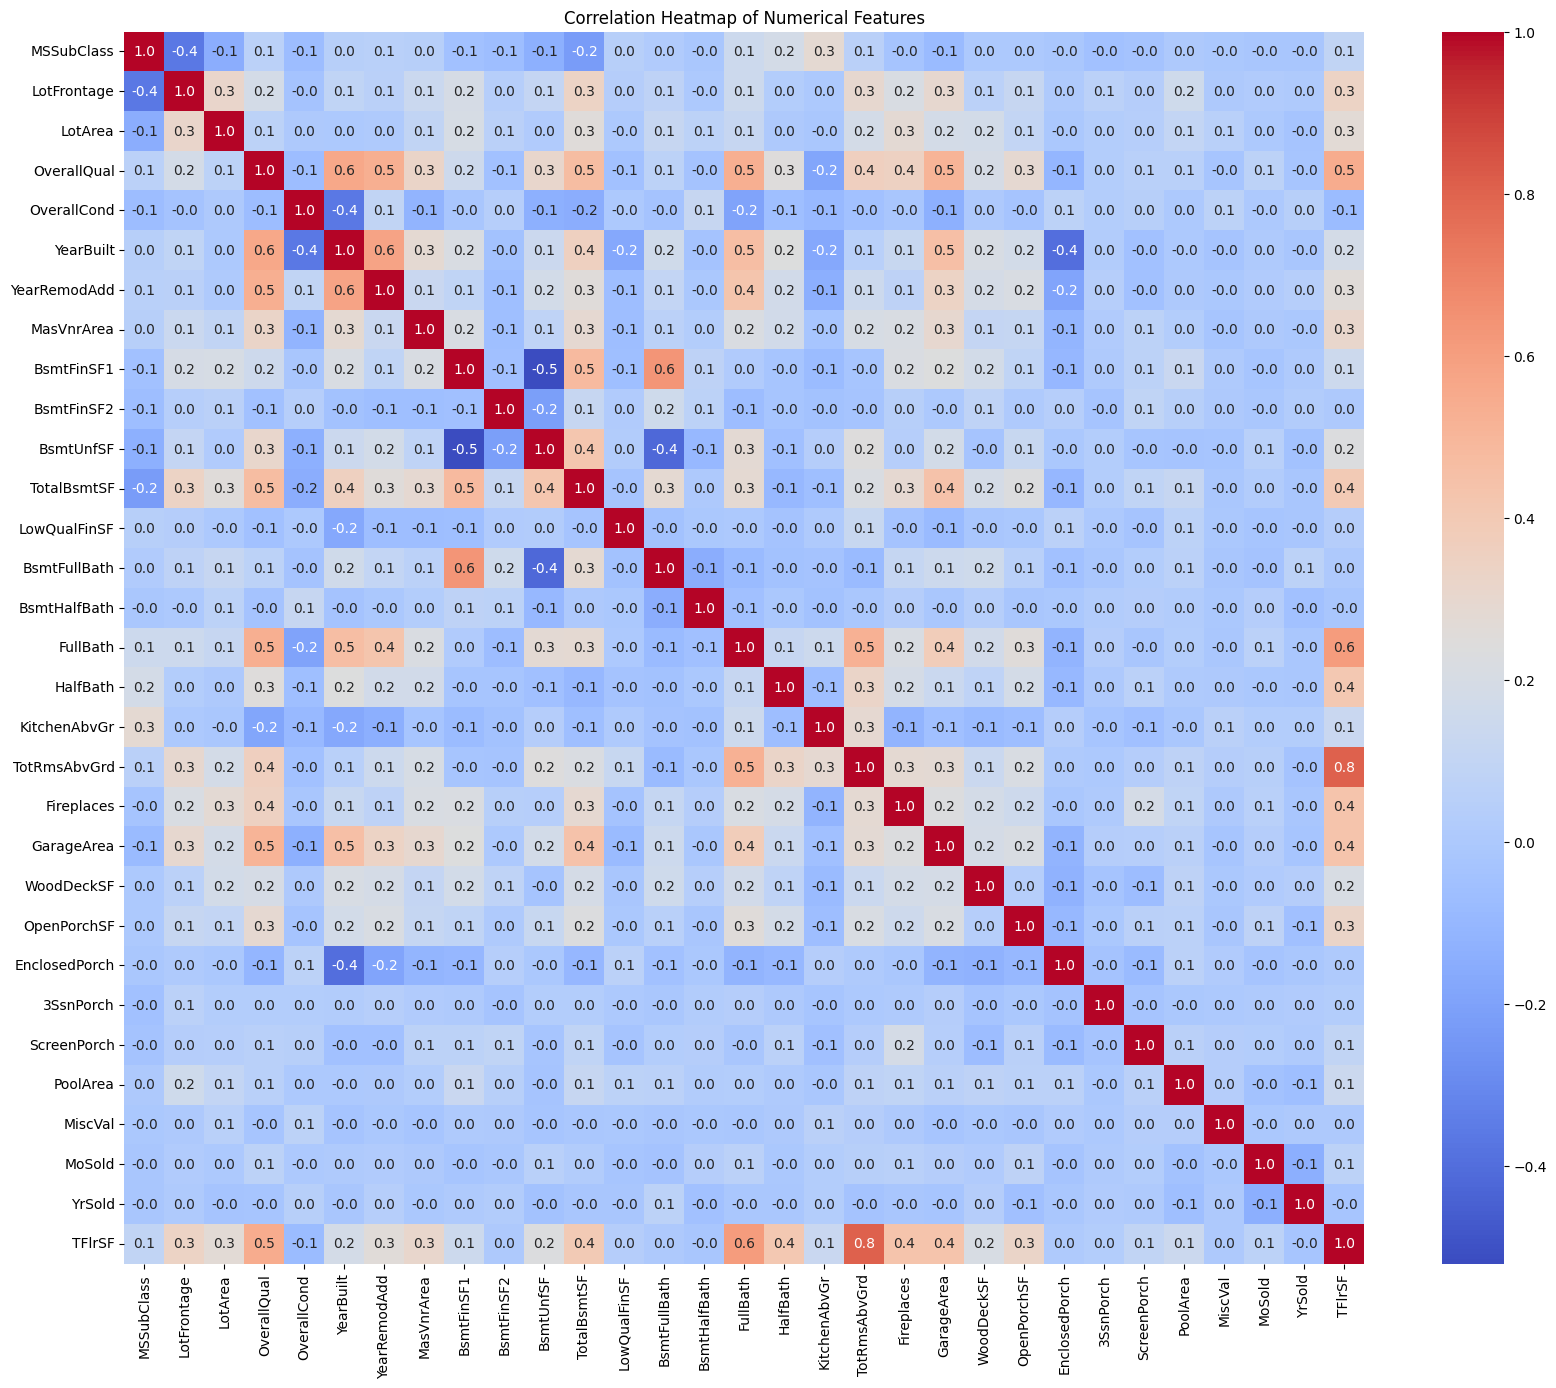

In [196]:
#check correlation for numerical features
num_feat = df.select_dtypes(['int', 'float']).drop('SalePrice', axis=1).corr()
plt.figure(figsize=(20, 16))
sns.heatmap(num_feat, cmap='coolwarm', annot=True, fmt='.1f')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

In [197]:
#num cols
num_feats = df.select_dtypes(['int', 'float']).drop('SalePrice', axis=1).columns
num_feats

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'TFlrSF'],
      dtype='object')

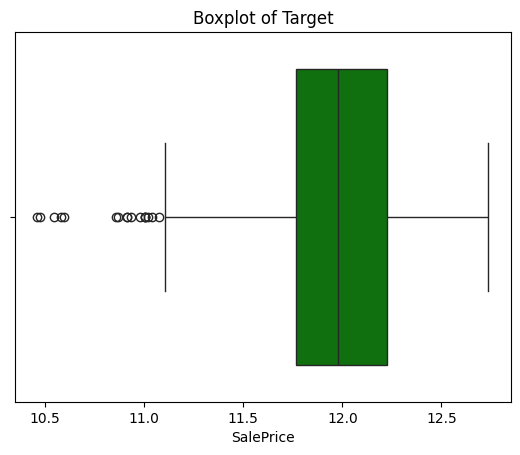

In [198]:
#target
sale = df['SalePrice']
#sale.plot(kind='box')
sns.boxplot(sale, orient='h', color='g')
plt.title('Boxplot of Target');


In [199]:
categorical_feat = df.select_dtypes('object')#.columns
#df[categorical_feat].head()
print('shape:', categorical_feat.shape)

shape: (1399, 37)


In [200]:
#get dummies
dummies = pd.get_dummies(categorical_feat, drop_first=True).astype(int)

print('shape of dummies:', dummies.shape)
print('shape of df', df.shape)

shape of dummies: (1399, 193)
shape of df (1399, 69)


In [201]:
dummies.head()

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,1,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [202]:
#numerical shape
numerical_feat = df.select_dtypes(['float', 'int'])
print('Shape of numerical df:', numerical_feat.shape)

Shape of numerical df: (1399, 32)


In [203]:
#join dfs
df_conc = pd.concat([dummies, numerical_feat], axis=1)
df_conc.shape

(1399, 225)

In [204]:
#target
target = 'SalePrice'
X = df_conc.drop(target, axis=1)
y = df_conc[target]

In [205]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [206]:
print('Size of X_train:', X_train.shape)
print('Size of X_test:', X_test.shape)
print('Size of y train:', y_train.shape)
print('Size of y test:', y_test.shape)

Size of X_train: (1119, 224)
Size of X_test: (280, 224)
Size of y train: (1119,)
Size of y test: (280,)


In [207]:
print(y_train.mean())

11.989353395493536


In [208]:
# y_train mean
y_train_mean = y_train.mean()
#rmse_baseline
y_pred_baseline  = len(y_train)*[y_train_mean]
rmse_baseline = np.sqrt(mean_squared_error(y_train, y_pred_baseline))

In [209]:
#instantiate model
model = LinearRegression()

#fit model to data
model.fit(X_train, y_train)

#predict on training data
y_pred_training = model.predict(X_train)
#print(y_pred_training.min())
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_training))

#predict on test data
y_pred_test = model.predict(X_test)
#print(y_pred_test.min())
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))



In [227]:
'''#tune random forest tree
def objective(trial):
    #hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_features': trial.suggest_float('max_features', 0.0, 1.0)
    }
    #instantiate model
    model = RandomForestRegressor(**params, random_state=42)
    #split
    kf = KFold(n_splits= 5, shuffle=True, random_state =42)
    #score
    scores = cross_val_score(model, X_train, y_train, scoring='neg_root_mean_squared_error', cv=kf)

    return -np.mean(scores)
#create study
study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=100)

#print best parameters
print('n estimators:', study.best_params['n_estimators'])
print('max depth:', study.best_params['max_depth'])
print('max features:', study.best_params['max_features'])'''





[I 2025-08-02 21:32:22,455] A new study created in memory with name: no-name-72c72259-1f62-4fe8-bea3-4f50918bfd70
[I 2025-08-02 21:32:41,080] Trial 0 finished with value: 0.13639888695049512 and parameters: {'n_estimators': 81, 'max_depth': 10, 'max_features': 0.7319939418114051}. Best is trial 0 with value: 0.13639888695049512.
[I 2025-08-02 21:32:47,845] Trial 1 finished with value: 0.172610152989979 and parameters: {'n_estimators': 124, 'max_depth': 4, 'max_features': 0.15599452033620265}. Best is trial 0 with value: 0.13639888695049512.
[I 2025-08-02 21:32:52,383] Trial 2 finished with value: 0.13933087362558227 and parameters: {'n_estimators': 21, 'max_depth': 9, 'max_features': 0.6011150117432088}. Best is trial 0 with value: 0.13639888695049512.
[I 2025-08-02 21:33:06,078] Trial 3 finished with value: 0.18305455951530508 and parameters: {'n_estimators': 145, 'max_depth': 3, 'max_features': 0.9699098521619943}. Best is trial 0 with value: 0.13639888695049512.
[I 2025-08-02 21:33:

n estimators: 189
max depth: 10
max features: 0.3799434925819317


In [211]:
#instantiate model
rf_model = RandomForestRegressor(n_estimators = 189, max_depth=10, max_features=0.3799434925819317, random_state=42)

#train model
rf_model.fit(X_train, y_train)

#predict on training
y_pred_train = rf_model.predict(X_train)

#error on training
rf_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

#predict on test set
y_pred_test = rf_model.predict(X_test)

#test error
rf_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))



In [212]:
'''#Get best parameters for gradient boosting
def objective(trial):
    
    #hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'max_features': trial.suggest_float('max_features', 0.0, 1.0),
        'min_samples_split': trial.suggest_float('min_samples_split', 0.0, 1.0),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 50)
    }
    
    #model instantiation
    model_gb = GradientBoostingRegressor(**params, random_state=42)
    
    #splits
    kf_gb = KFold(n_splits=5, shuffle=True, random_state =42)
    
    #get scores
    scores_gb = cross_val_score(model_gb, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv=kf_gb)

    return -np.mean(scores_gb)

study_gb = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study_gb.optimize(objective, n_trials=100)''''''






[I 2025-08-02 13:27:13,128] A new study created in memory with name: no-name-a6c6c377-fcdc-4935-9552-6c63e0c5a2bc


[I 2025-08-02 13:27:24,361] Trial 0 finished with value: 0.18266336174412207 and parameters: {'n_estimators': 118, 'learning_rate': 0.9507635921035062, 'max_depth': 8, 'max_features': 0.5986584841970366, 'min_samples_split': 0.15601864044243652, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.18266336174412207.
[I 2025-08-02 13:27:26,566] Trial 1 finished with value: 0.1594046699462235 and parameters: {'n_estimators': 26, 'learning_rate': 0.8663099696291603, 'max_depth': 7, 'max_features': 0.7080725777960455, 'min_samples_split': 0.020584494295802447, 'min_samples_leaf': 49}. Best is trial 1 with value: 0.1594046699462235.
[I 2025-08-02 13:27:34,101] Trial 2 finished with value: 0.12620879074456598 and parameters: {'n_estimators': 252, 'learning_rate': 0.21312677156759788, 'max_depth': 4, 'max_features': 0.18340450985343382, 'min_samples_split': 0.3042422429595377, 'min_samples_leaf': 27}. Best is trial 2 with value: 0.12620879074456598.
[I 2025-08-02 13:27:38,142] Trial 3 finish

In [213]:
'''#print best parameters
print('n estimators:', study_gb.best_params['n_estimators'])
print('max depth:', study_gb.best_params['max_depth'])
print('max features:', study_gb.best_params['max_features'])
print('min_samples_split:', study_gb.best_params['min_samples_split'])
print('learning_rate:', study_gb.best_params['learning_rate'])
print('min_samples_leaf:', study_gb.best_params['min_samples_leaf'])'''

n estimators: 295
max depth: 8
max features: 0.2501444402497654
min_samples_split: 0.6918331676648537
learning_rate: 0.24064916215978
min_samples_leaf: 19


In [214]:
#instantiate model
gb_model = GradientBoostingRegressor(learning_rate = 0.24064916215978, min_samples_leaf =19, n_estimators = 295, max_depth=8, max_features=0.2501444402497654, min_samples_split=0.6918331676648537, random_state=42)

#train model
gb_model.fit(X_train, y_train)

#predict on training
y_pred_training = gb_model.predict(X_train)

#error on training
gb_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_training))

#predict on test set
y_pred_testing = gb_model.predict(X_test)

#test error
gb_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_testing))



In [215]:
'''#Get best parameters for adaptive boosting
def objective(trial):
    
    #hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1.0),
        
    }
    
    #model instantiation
    ada_model = AdaBoostRegressor(**params, random_state=42)
    
    #splits
    kf_ada = KFold(n_splits=5, shuffle=True, random_state=42)
    
    #get scores
    scores_ada = cross_val_score(ada_model, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv=kf_ada)

    return -np.mean(scores_ada)

study_ada = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study_ada.optimize(objective, n_trials=100)'''





[I 2025-08-02 13:55:56,056] A new study created in memory with name: no-name-61d96f1a-8596-4f57-bcc6-ad6f216c92bb


[I 2025-08-02 13:56:07,901] Trial 0 finished with value: 0.1659619535895565 and parameters: {'n_estimators': 118, 'learning_rate': 0.9507635921035062}. Best is trial 0 with value: 0.1659619535895565.
[I 2025-08-02 13:56:29,863] Trial 1 finished with value: 0.16705735463474342 and parameters: {'n_estimators': 223, 'learning_rate': 0.5990598257128396}. Best is trial 0 with value: 0.1659619535895565.
[I 2025-08-02 13:56:37,378] Trial 2 finished with value: 0.17003382413767376 and parameters: {'n_estimators': 55, 'learning_rate': 0.15683852581586644}. Best is trial 0 with value: 0.1659619535895565.
[I 2025-08-02 13:56:40,301] Trial 3 finished with value: 0.16909577636061704 and parameters: {'n_estimators': 26, 'learning_rate': 0.8663099696291603}. Best is trial 0 with value: 0.1659619535895565.
[I 2025-08-02 13:56:58,874] Trial 4 finished with value: 0.16840286003965188 and parameters: {'n_estimators': 184, 'learning_rate': 0.7083645052182495}. Best is trial 0 with value: 0.165961953589556

In [216]:
'''#print best parameters
print('n estimators:', study_ada.best_params['n_estimators'])

print('learning_rate:', study_ada.best_params['learning_rate'])'''

n estimators: 98
learning_rate: 0.5252316752006057


In [217]:
#instantiate model
ad_model = AdaBoostRegressor(n_estimators = 98, learning_rate= 0.5252316752006057, random_state=42)

#train model
ad_model.fit(X_train, y_train)

#predict on training
y_pred_train = ad_model.predict(X_train)

#error on training
ad_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

#predict on test set
y_pred_test = ad_model.predict(X_test)

#test error
ad_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [218]:
'''#Get best parameters for decision tree regressor
def objective(trial):
    
    #hyperparameters
    params = {
        'max_depth': trial.suggest_int('max_depth', 10, 300),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'min_weight_fraction_leaf': trial.suggest_float('min_weight_fraction_leaf', 0.0, 0.5),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 50),
        
    }
    
    #model instantiation
    dtr_model = DecisionTreeRegressor(**params, random_state=42)
    
    #splits
    dtr_kf = KFold(n_splits=5, shuffle=True, random_state =42)
    
    #get scores
    scores_dtr = cross_val_score(dtr_model, X_train, y_train, scoring = 'neg_root_mean_squared_error', cv=dtr_kf)

    return -np.mean(scores_dtr)

study_dtr = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
study_dtr.optimize(objective, n_trials=100)

#print best parameters
print('min_weight_fraction_leaf:', study_dtr.best_params['min_weight_fraction_leaf'])
print('max depth:', study_dtr.best_params['max_depth'])
print('max_leaf_nodes:', study_dtr.best_params['max_leaf_nodes'])
print('min_samples_split:', study_dtr.best_params['min_samples_split'])
print('min_samples_leaf:', study_dtr.best_params['min_samples_leaf'])'''

[I 2025-08-02 14:29:54,970] A new study created in memory with name: no-name-bdce8d4f-e920-4adf-b039-62342537db0a


[I 2025-08-02 14:29:55,842] Trial 0 finished with value: 0.247493996600348 and parameters: {'max_depth': 118, 'min_samples_split': 48, 'min_samples_leaf': 37, 'min_weight_fraction_leaf': 0.2993292420985183, 'max_leaf_nodes': 9}. Best is trial 0 with value: 0.247493996600348.
[I 2025-08-02 14:29:56,127] Trial 1 finished with value: 0.2476832266938241 and parameters: {'max_depth': 55, 'min_samples_split': 4, 'min_samples_leaf': 44, 'min_weight_fraction_leaf': 0.3005575058716044, 'max_leaf_nodes': 36}. Best is trial 0 with value: 0.247493996600348.
[I 2025-08-02 14:29:56,373] Trial 2 finished with value: 0.21853157285696626 and parameters: {'max_depth': 15, 'min_samples_split': 49, 'min_samples_leaf': 42, 'min_weight_fraction_leaf': 0.10616955533913808, 'max_leaf_nodes': 10}. Best is trial 2 with value: 0.21853157285696626.
[I 2025-08-02 14:29:56,810] Trial 3 finished with value: 0.24751971119752056 and parameters: {'max_depth': 63, 'min_samples_split': 16, 'min_samples_leaf': 27, 'min_we

min_weight_fraction_leaf: 0.01667993376678938
max depth: 58
max_leaf_nodes: 44
min_samples_split: 5
min_samples_leaf: 4


In [219]:
#instantiate model
dtr_model = DecisionTreeRegressor(max_depth=58, min_samples_leaf=4, min_samples_split=5, min_weight_fraction_leaf=0.01667993376678938, max_leaf_nodes=44, random_state=42)

#train model
dtr_model.fit(X_train, y_train)

#predict on training
y_pred_train = dtr_model.predict(X_train)

#error on training
dtr_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

#predict on test set
y_pred_test = dtr_model.predict(X_test)

#test error
dtr_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))

In [220]:
print('''Based on the results below, it is clear that Gradient boosting has the lowest testing error, followed by random forest. 
Third in the row in the ada boost model. yet,  ada boost model produces the least difference between the training and testing errors.
 this if followed by gradient boosting decision tree and random forest. It follows, therefore, that if we are to stack models, 
 adaboosting, random forest, and gradient boosting provides the most feassible models.''')
print('x----------------------------------x')
print('***Linear Regression Results***')

print('RMSE baseline', rmse_baseline)
print('Linear RMSE Training:', rmse_train)
print('Linear RMSE Testing:', rmse_test)

print('x----------------------------------x')
print('***Random Forest Results***')

print('RF RMSE baseline', rmse_baseline)
print('RF RMSE Training:', rf_rmse_train)
print('RF RMSE Testing:', rf_rmse_test)

print('x----------------------------------x')
print('***Gradient Boosting Results***')

print('GB RMSE baseline', rmse_baseline)
print('GB RMSE Training:', gb_rmse_train)
print('GB RMSE Testing:', gb_rmse_test)

print('x----------------------------------x')
print('***Ada Boosting Results***')

print('ADA RMSE baseline', rmse_baseline)
print('ADA RMSE Training:', ad_rmse_train)
print('ADA RMSE Testing:', ad_rmse_test)

print('x----------------------------------x')
print('***Decision Tree***')

print('DTR RMSE baseline', rmse_baseline)
print('DTR RMSE Training:', dtr_rmse_train)
print('DTR RMSE Testing:', dtr_rmse_test)

print('x----------------------------------x')


Based on the results below, it is clear that Gradient boosting has the lowest testing error, followed by random forest. 
Third in the row in the ada boost model. yet,  ada boost model produces the least difference between the training and testing errors.
 this if followed by gradient boosting decision tree and random forest. It follows, therefore, that if we are to stack models, 
 adaboosting, random forest, and gradient boosting provides the most feassible models.
x----------------------------------x
***Linear Regression Results***
RMSE baseline 0.3591739361224703
Linear RMSE Training: 0.09159070648016988
Linear RMSE Testing: 0.2865975732446605
x----------------------------------x
***Random Forest Results***
RF RMSE baseline 0.3591739361224703
RF RMSE Training: 0.05901924964448673
RF RMSE Testing: 0.12277113316812721
x----------------------------------x
***Gradient Boosting Results***
GB RMSE baseline 0.3591739361224703
GB RMSE Training: 0.07154979013864156
GB RMSE Testing: 0.11463385

In [221]:
'''def objective(trial):
    # Suggest alpha for Ridge
    alpha = trial.suggest_float('alpha', 1e-4, 100.0, log=True)

    # Base learners
    base_learners = [
        ('rf', RandomForestRegressor(random_state=42)),
        ('gb', GradientBoostingRegressor(random_state=42)),
        ('ada', AdaBoostRegressor(random_state=42))
    ]

    # Ridge as meta-learner with trial alpha
    meta_learner = Ridge(alpha=alpha)

    # Stacking model
    stack_model = StackingRegressor(
        estimators=base_learners,
        final_estimator=meta_learner,
        cv=5,
        n_jobs=-1
    )

    # Fit and evaluate
    stack_model.fit(X_train, y_train)
    y_pred = stack_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Run Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best result
print("Best alpha:", study.best_params['alpha'])
print("Best RMSE:", study.best_value)'''

[I 2025-08-02 14:30:45,066] A new study created in memory with name: no-name-4ff1bba6-b7f6-488d-874b-8ae062480dd4
[I 2025-08-02 14:31:47,431] Trial 0 finished with value: 0.12377723635732425 and parameters: {'alpha': 0.04483936207255593}. Best is trial 0 with value: 0.12377723635732425.
[I 2025-08-02 14:32:31,247] Trial 1 finished with value: 0.12237958900745224 and parameters: {'alpha': 1.4981786935447412}. Best is trial 1 with value: 0.12237958900745224.
[I 2025-08-02 14:33:22,627] Trial 2 finished with value: 0.12383313251245193 and parameters: {'alpha': 0.014913386661690193}. Best is trial 1 with value: 0.12237958900745224.
[I 2025-08-02 14:34:29,948] Trial 3 finished with value: 0.1218511509731621 and parameters: {'alpha': 6.115864762013358}. Best is trial 3 with value: 0.1218511509731621.
[I 2025-08-02 14:35:18,727] Trial 4 finished with value: 0.1256709481348199 and parameters: {'alpha': 39.465264578631725}. Best is trial 3 with value: 0.1218511509731621.
[I 2025-08-02 14:36:01,

Best alpha: 4.692942305908861
Best RMSE: 0.12184079296220353


In [228]:
#base learners
base_learners = [
    ('rf', RandomForestRegressor(n_estimators = 189, max_depth=10, max_features=0.3799434925819317, random_state=42)),
    ('gb', GradientBoostingRegressor(learning_rate = 0.24064916215978, min_samples_leaf =19, n_estimators = 295, max_depth=8, max_features=0.2501444402497654, min_samples_split=0.6918331676648537, random_state=42)),
    ('ada', AdaBoostRegressor(n_estimators = 98, learning_rate= 0.5252316752006057, random_state=42)),
    ('dc', DecisionTreeRegressor(max_depth=58, min_samples_leaf=4, min_samples_split=5, min_weight_fraction_leaf=0.01667993376678938, max_leaf_nodes=44, random_state=42))

]

#meta learner
meta_learner = Ridge(alpha=5.23092697428031)

In [229]:
#stack model
stack_model = StackingRegressor(
    estimators= base_learners, 
    final_estimator=meta_learner, 
    cv= 5, 
    n_jobs=-1, 
)

In [230]:
stack_model.fit(X_train, y_train)

#predict on training
y_pred_train = stack_model.predict(X_train)

#error on training
stack_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))

#predict on test set
y_pred_test = stack_model.predict(X_test)

#test error
stack_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))



#print results
print('stack rmse baseline', rmse_baseline)
print('stack rmse training:', stack_rmse_train)
print('stack rmse testing:', stack_rmse_test)

In [226]:
'''def objective(trial):
    # Suggest alpha for Ridge
    alpha = trial.suggest_float('alpha', 1e-4, 100.0, log=True)

    # Base learners
    base_learners = [
        ('rf', RandomForestRegressor(random_state=42)),
        ('gb', GradientBoostingRegressor(random_state=42)),
        ('ada', AdaBoostRegressor(random_state=42))
    ]

    # Ridge as meta-learner with trial alpha
    meta_learner = Ridge(alpha=alpha)

    # Stacking model
    stack_model = StackingRegressor(
        estimators=base_learners,
        final_estimator=meta_learner,
        cv=5,
        n_jobs=-1
    )

    # Fit and evaluate
    stack_model.fit(X_train, y_train)
    y_pred = stack_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse

# Run Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best result
print("Best alpha:", study.best_params['alpha'])
print("Best RMSE:", study.best_value)'''

[I 2025-08-02 20:46:46,188] A new study created in memory with name: no-name-40000cf0-4255-4b05-b648-f1e1a03ef895


[I 2025-08-02 20:47:51,865] Trial 0 finished with value: 0.12386126983114133 and parameters: {'alpha': 0.00024384920798858515}. Best is trial 0 with value: 0.12386126983114133.
[I 2025-08-02 20:48:58,225] Trial 1 finished with value: 0.1238611857019781 and parameters: {'alpha': 0.00028732721993732815}. Best is trial 1 with value: 0.1238611857019781.
[I 2025-08-02 20:50:04,945] Trial 2 finished with value: 0.12365852706758745 and parameters: {'alpha': 0.11210326013347023}. Best is trial 2 with value: 0.12365852706758745.
[I 2025-08-02 20:51:07,766] Trial 3 finished with value: 0.12385913342417881 and parameters: {'alpha': 0.0013486516144289226}. Best is trial 2 with value: 0.12365852706758745.
[I 2025-08-02 20:52:07,188] Trial 4 finished with value: 0.12386120468278432 and parameters: {'alpha': 0.00027751772666240155}. Best is trial 2 with value: 0.12365852706758745.
[I 2025-08-02 20:52:59,533] Trial 5 finished with value: 0.12385990497298172 and parameters: {'alpha': 0.0009494901836594

Best alpha: 5.23092697428031
Best RMSE: 0.12183703200682976


In [ ]:
#define wrangle function
def wrangle_test(dataset):
    
    #read csv
    df = pd.read_csv(dataset)
    
    #copy ids
    house_ids = df['Id'].copy()
    
    #cols to drop
    cols_to_drop = ['PoolQC','Alley','MiscFeature','Fence', 'FireplaceQu','MasVnrType', 'Id']

    #handle categorical missingness
    categ_vars = df.select_dtypes('object').columns
    for cat_col in categ_vars:
        df[cat_col] = df[cat_col].fillna(df[cat_col].mode()[0])
    
    #handle numerical missingness
    num_cols = df.select_dtypes(['int','float']).columns
    for num in num_cols:
        df[num] = df[num].fillna(df[num].mean())
    
    #drop multicollinearity
    collinear = ['BedroomAbvGr', 'GarageYrBlt', '2ndFlrSF', '1stFlrSF', 'GarageCars', 'GrLivArea']
    
    #append
    cols_to_drop.extend(collinear)

    #drop cols
    df.drop(columns = cols_to_drop, inplace=True)
    
    #get dummies
    df = pd.get_dummies(df).astype('int')

    # Align with training data
    df = df.reindex(columns=X_train.columns, fill_value=0)

    return df, house_ids

In [ ]:
#read test csv
test, id = wrangle_test('test.csv')

#print head
print('Test shape:', test.shape)
print('Id shape:', id.shape)


Test shape: (1459, 224)
Id shape: (1459,)


In [ ]:
id.head()

0    1461
1    1462
2    1463
3    1464
4    1465
Name: Id, dtype: int64

In [ ]:
#generate predictions based of test csv
predictions = stack_model.predict(test)

In [ ]:
submission_fixed = pd.DataFrame({
    'Id': id,
    'SalePrice': np.expm1(predictions)
})
submission_fixed.to_csv('predictions.csv', index=False)



In [ ]:
#check submission
submission_fixed.head()

,Id,SalePrice
0,1461,111623.106086
1,1462,124287.328717
2,1463,135035.968902
3,1464,139212.398880
4,1465,161091.549639


In [ ]:
#read csv
print(pd.read_csv('predictions.csv').head())

     Id      SalePrice
0  1461  111623.106086
1  1462  124287.328717
2  1463  135035.968902
3  1464  139212.398880
4  1465  161091.549639
